In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      input_shape=input_shape))
    model.add(Activation('tanh'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same'))
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(Activation('tanh'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_22 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_44 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_74 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7269 - acc: 0.0979
Epoch 00001: val_loss improved from inf to 2.72619, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_1_conv_checkpoint/001-2.7262.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.7269 - acc: 0.0979 - val_loss: 2.7262 - val_acc: 0.0964
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4789 - acc: 0.2557
Epoch 00002: val_loss did not improve from 2.72619
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.4790 - acc: 0.2557 - val_loss: 2.8644 - val_acc: 0.1214
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9882 - acc: 0.4138
Epoch 00003: val_loss did not improve from 2.72619
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.9882 - acc: 0.4139 - val_loss: 3.

36800/36805 [============================>.] - ETA: 0s - loss: 0.3037 - acc: 0.9078
Epoch 00029: val_loss did not improve from 2.72619
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3038 - acc: 0.9078 - val_loss: 10.1887 - val_acc: 0.1053
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2851 - acc: 0.9127
Epoch 00030: val_loss did not improve from 2.72619
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2852 - acc: 0.9126 - val_loss: 10.2863 - val_acc: 0.1051
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2726 - acc: 0.9151
Epoch 00031: val_loss did not improve from 2.72619
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2726 - acc: 0.9151 - val_loss: 10.3630 - val_acc: 0.1048
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2699 - acc: 0.9175
Epoch 00032: val_loss did not improve from 2.72619
36805/36805 [=====================

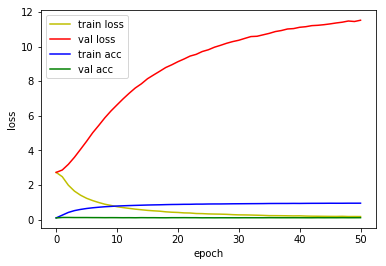

4815/4815 [==============================] - 2s 477us/sample - loss: 2.7204 - acc: 0.1001
Loss: 2.7204171821954715 Accuracy: 0.10010384

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3266 - acc: 0.2604
Epoch 00001: val_loss improved from inf to 2.09603, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_2_conv_checkpoint/001-2.0960.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.3266 - acc: 0.2604 - val_loss: 2.0960 - val_acc: 0.3452
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7804 - acc: 0.4453
Epoch 00002: val_loss improved from 2.09603 to 2.05232, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_2_conv_checkpoint/002-2.0523.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 1.7804 - acc: 0.4453 - val_loss: 2.0523 - val_acc: 0.3592
Epoch 3/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.1159 - acc: 0.9652
Epoch 00029: val_loss did not improve from 2.05232
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1159 - acc: 0.9652 - val_loss: 4.4460 - val_acc: 0.3890
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1107 - acc: 0.9670
Epoch 00030: val_loss did not improve from 2.05232
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1111 - acc: 0.9670 - val_loss: 4.5304 - val_acc: 0.4016
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1047 - acc: 0.9688
Epoch 00031: val_loss did not improve from 2.05232
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1048 - acc: 0.9688 - val_loss: 4.5335 - val_acc: 0.4016
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1079 - acc: 0.9674
Epoch 00032: val_loss did not improve from 2.05232
36805/36805 [========================

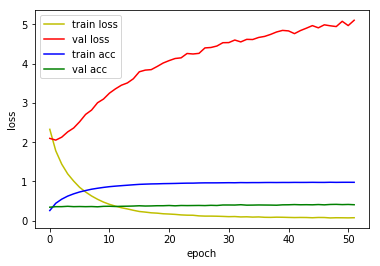

4815/4815 [==============================] - 4s 789us/sample - loss: 2.0918 - acc: 0.3421
Loss: 2.09183182830256 Accuracy: 0.34205607

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9764 - acc: 0.3709
Epoch 00001: val_loss improved from inf to 1.61441, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_3_conv_checkpoint/001-1.6144.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.9764 - acc: 0.3709 - val_loss: 1.6144 - val_acc: 0.4936
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4233 - acc: 0.5567
Epoch 00002: val_loss improved from 1.61441 to 1.51607, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_3_conv_checkpoint/002-1.5161.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.4234 - acc: 0.5567 - val_loss: 1.5161 - val_acc: 0.5276
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9823
Epoch 00029: val_loss did not improve from 1.45825
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0702 - acc: 0.9823 - val_loss: 2.1381 - val_acc: 0.6115
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9839
Epoch 00030: val_loss did not improve from 1.45825
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0652 - acc: 0.9839 - val_loss: 2.1402 - val_acc: 0.6166
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9832
Epoch 00031: val_loss did not improve from 1.45825
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0667 - acc: 0.9832 - val_loss: 2.1857 - val_acc: 0.6112
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0657 - acc: 0.9835
Epoch 00032: val_loss did not improve from 1.45825
36805/36805 [===========

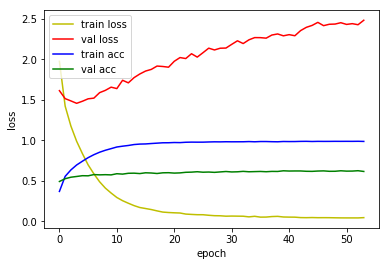

4815/4815 [==============================] - 4s 906us/sample - loss: 1.5243 - acc: 0.5333
Loss: 1.524274631452709 Accuracy: 0.53333336

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8320 - acc: 0.4102
Epoch 00001: val_loss improved from inf to 1.45530, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_4_conv_checkpoint/001-1.4553.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.8320 - acc: 0.4101 - val_loss: 1.4553 - val_acc: 0.5553
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3176 - acc: 0.5951
Epoch 00002: val_loss improved from 1.45530 to 1.23744, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_4_conv_checkpoint/002-1.2374.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.3176 - acc: 0.5951 - val_loss: 1.2374 - val_acc: 0.6233
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1712 - acc: 0.9541
Epoch 00027: val_loss did not improve from 1.01536
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1712 - acc: 0.9541 - val_loss: 1.1160 - val_acc: 0.7314
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1583 - acc: 0.9576
Epoch 00028: val_loss did not improve from 1.01536
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1583 - acc: 0.9576 - val_loss: 1.1445 - val_acc: 0.7317
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1495 - acc: 0.9608
Epoch 00029: val_loss did not improve from 1.01536
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1495 - acc: 0.9608 - val_loss: 1.1455 - val_acc: 0.7361
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1505 - acc: 0.9609
Epoch 00030: val_loss did not improve from 1.01536
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0642 - acc: 0.9840
Epoch 00057: val_loss did not improve from 1.01536
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0642 - acc: 0.9840 - val_loss: 1.2831 - val_acc: 0.7452
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0658 - acc: 0.9826
Epoch 00058: val_loss did not improve from 1.01536
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0658 - acc: 0.9826 - val_loss: 1.3115 - val_acc: 0.7491
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9842
Epoch 00059: val_loss did not improve from 1.01536
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0598 - acc: 0.9842 - val_loss: 1.3023 - val_acc: 0.7470
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0597 - acc: 0.9847
Epoch 00060: val_loss did not improve from 1.01536
36805/36805 [===========

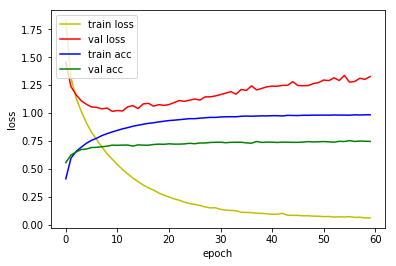

4815/4815 [==============================] - 5s 963us/sample - loss: 1.0789 - acc: 0.6908
Loss: 1.0788706494764129 Accuracy: 0.69075805

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7890 - acc: 0.4242
Epoch 00001: val_loss improved from inf to 1.42957, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_5_conv_checkpoint/001-1.4296.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 1.7891 - acc: 0.4242 - val_loss: 1.4296 - val_acc: 0.5658
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3650 - acc: 0.5788
Epoch 00002: val_loss improved from 1.42957 to 1.24471, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_5_conv_checkpoint/002-1.2447.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.3650 - acc: 0.5788 - val_loss: 1.2447 - val_acc: 0.6282
Epoch 3/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.2990 - acc: 0.9158
Epoch 00024: val_loss did not improve from 0.74633
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2991 - acc: 0.9157 - val_loss: 0.7538 - val_acc: 0.7929
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2915 - acc: 0.9169
Epoch 00025: val_loss did not improve from 0.74633
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2915 - acc: 0.9169 - val_loss: 0.7960 - val_acc: 0.7836
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2722 - acc: 0.9214
Epoch 00026: val_loss did not improve from 0.74633
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2723 - acc: 0.9214 - val_loss: 0.7781 - val_acc: 0.7950
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2589 - acc: 0.9267
Epoch 00027: val_loss did not improve from 0.74633
36805/36805 [========================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9750
Epoch 00054: val_loss did not improve from 0.74633
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0901 - acc: 0.9750 - val_loss: 0.9134 - val_acc: 0.7941
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0856 - acc: 0.9771
Epoch 00055: val_loss did not improve from 0.74633
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0856 - acc: 0.9771 - val_loss: 0.8820 - val_acc: 0.8095
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0890 - acc: 0.9751
Epoch 00056: val_loss did not improve from 0.74633
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0890 - acc: 0.9751 - val_loss: 0.8931 - val_acc: 0.7957
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9770
Epoch 00057: val_loss did not improve from 0.74633
36805/36805 [===========

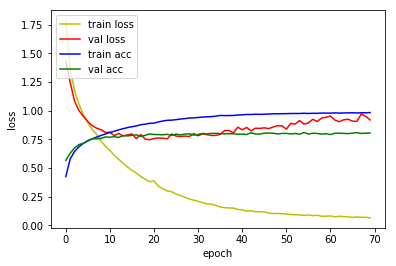

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8261 - acc: 0.7659
Loss: 0.8260591631985403 Accuracy: 0.7659398

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8535 - acc: 0.3998
Epoch 00001: val_loss improved from inf to 1.45381, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/001-1.4538.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 1.8534 - acc: 0.3998 - val_loss: 1.4538 - val_acc: 0.5595
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4256 - acc: 0.5573
Epoch 00002: val_loss improved from 1.45381 to 1.19158, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/002-1.1916.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.4256 - acc: 0.5573 - val_loss: 1.1916 - val_acc: 0.6415
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4320 - acc: 0.8745
Epoch 00023: val_loss did not improve from 0.49231
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.4319 - acc: 0.8745 - val_loss: 0.5135 - val_acc: 0.8570
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4125 - acc: 0.8803
Epoch 00024: val_loss improved from 0.49231 to 0.48090, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/024-0.4809.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.4124 - acc: 0.8803 - val_loss: 0.4809 - val_acc: 0.8675
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3999 - acc: 0.8842
Epoch 00025: val_loss improved from 0.48090 to 0.47704, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/025-0.4770.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3999 - acc: 0.8842

36800/36805 [============================>.] - ETA: 0s - loss: 0.2066 - acc: 0.9400
Epoch 00049: val_loss did not improve from 0.40688
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2066 - acc: 0.9400 - val_loss: 0.4192 - val_acc: 0.8910
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2013 - acc: 0.9398
Epoch 00050: val_loss improved from 0.40688 to 0.40326, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/050-0.4033.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2013 - acc: 0.9398 - val_loss: 0.4033 - val_acc: 0.8947
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2002 - acc: 0.9395
Epoch 00051: val_loss did not improve from 0.40326
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2002 - acc: 0.9395 - val_loss: 0.4137 - val_acc: 0.8884
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.19

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9660
Epoch 00078: val_loss did not improve from 0.40107
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1121 - acc: 0.9660 - val_loss: 0.4371 - val_acc: 0.8938
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1047 - acc: 0.9692
Epoch 00079: val_loss did not improve from 0.40107
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1047 - acc: 0.9692 - val_loss: 0.4291 - val_acc: 0.8987
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1066 - acc: 0.9678
Epoch 00080: val_loss did not improve from 0.40107
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1065 - acc: 0.9678 - val_loss: 0.4371 - val_acc: 0.8935
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1020 - acc: 0.9698
Epoch 00081: val_loss did not improve from 0.40107
36805/36805 [===========

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9812
Epoch 00108: val_loss did not improve from 0.40107
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0674 - acc: 0.9812 - val_loss: 0.4372 - val_acc: 0.8987
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0661 - acc: 0.9812
Epoch 00109: val_loss did not improve from 0.40107
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0661 - acc: 0.9812 - val_loss: 0.4549 - val_acc: 0.9001

1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv Model


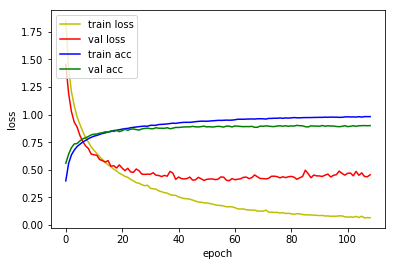

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4952 - acc: 0.8627
Loss: 0.4951543708085271 Accuracy: 0.86272067

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9570 - acc: 0.3617
Epoch 00001: val_loss improved from inf to 1.48582, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/001-1.4858.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 1.9569 - acc: 0.3617 - val_loss: 1.4858 - val_acc: 0.5344
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4683 - acc: 0.5340
Epoch 00002: val_loss improved from 1.48582 to 1.18410, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/002-1.1841.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.4682 - acc: 0.5340 - val_loss: 1.1841 - val_acc: 0.6622
Epoch 3/500
36800/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 0.3069 - acc: 0.9116
Epoch 00023: val_loss improved from 0.30554 to 0.28991, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/023-0.2899.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3069 - acc: 0.9116 - val_loss: 0.2899 - val_acc: 0.9189
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2962 - acc: 0.9154
Epoch 00024: val_loss did not improve from 0.28991
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2962 - acc: 0.9154 - val_loss: 0.3057 - val_acc: 0.9131
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2927 - acc: 0.9145
Epoch 00025: val_loss improved from 0.28991 to 0.28044, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/025-0.2804.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2927 - acc: 0.9145 - val_loss: 

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1483 - acc: 0.9556
Epoch 00050: val_loss improved from 0.22881 to 0.22030, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/050-0.2203.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1483 - acc: 0.9556 - val_loss: 0.2203 - val_acc: 0.9439
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1470 - acc: 0.9558
Epoch 00051: val_loss improved from 0.22030 to 0.21515, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/051-0.2151.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1470 - acc: 0.9558 - val_loss: 0.2151 - val_acc: 0.9411
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1425 - acc: 0.9569
Epoch 00052: val_loss did not improve from 0.21515
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1425 - acc: 0.9569

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0801 - acc: 0.9772
Epoch 00079: val_loss did not improve from 0.21515
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0801 - acc: 0.9772 - val_loss: 0.2356 - val_acc: 0.9457
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0747 - acc: 0.9780
Epoch 00080: val_loss did not improve from 0.21515
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0747 - acc: 0.9780 - val_loss: 0.2340 - val_acc: 0.9460
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0726 - acc: 0.9784
Epoch 00081: val_loss did not improve from 0.21515
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0726 - acc: 0.9784 - val_loss: 0.2421 - val_acc: 0.9434
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0700 - acc: 0.9792
Epoch 00082: val_loss did not improve from 0.21515
36805/36805 [===========

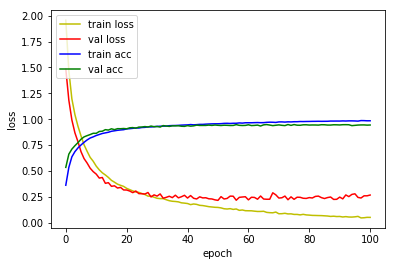

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2559 - acc: 0.9246
Loss: 0.255949091651358 Accuracy: 0.9246106

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9407 - acc: 0.3754
Epoch 00001: val_loss improved from inf to 1.44203, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_8_conv_checkpoint/001-1.4420.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 1.9405 - acc: 0.3754 - val_loss: 1.4420 - val_acc: 0.5549
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3642 - acc: 0.5751
Epoch 00002: val_loss improved from 1.44203 to 1.00884, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_8_conv_checkpoint/002-1.0088.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.3643 - acc: 0.5750 - val_loss: 1.0088 - val_acc: 0.7058
Epoch 3/500
36800/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 0.1799 - acc: 0.9457
Epoch 00023: val_loss did not improve from 0.16294
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1799 - acc: 0.9457 - val_loss: 0.1659 - val_acc: 0.9525
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1724 - acc: 0.9484
Epoch 00024: val_loss did not improve from 0.16294
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1724 - acc: 0.9484 - val_loss: 0.1747 - val_acc: 0.9499
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1679 - acc: 0.9511
Epoch 00025: val_loss did not improve from 0.16294
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1680 - acc: 0.9511 - val_loss: 0.1666 - val_acc: 0.9546
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1599 - acc: 0.9523
Epoch 00026: val_loss improved from 0.16294 to 0.14459, saving model to model/checkpoint

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9817
Epoch 00052: val_loss did not improve from 0.13625
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0592 - acc: 0.9817 - val_loss: 0.1560 - val_acc: 0.9550
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0527 - acc: 0.9848
Epoch 00053: val_loss did not improve from 0.13625
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0527 - acc: 0.9848 - val_loss: 0.1458 - val_acc: 0.9546
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0519 - acc: 0.9840
Epoch 00054: val_loss did not improve from 0.13625
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0519 - acc: 0.9841 - val_loss: 0.1629 - val_acc: 0.9525
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9830
Epoch 00055: val_loss did not improve from 0.13625
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9945
Epoch 00082: val_loss did not improve from 0.13625
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0200 - acc: 0.9945 - val_loss: 0.2216 - val_acc: 0.9502
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9923
Epoch 00083: val_loss did not improve from 0.13625
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0267 - acc: 0.9923 - val_loss: 0.1861 - val_acc: 0.9557
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9959
Epoch 00084: val_loss did not improve from 0.13625
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0162 - acc: 0.9959 - val_loss: 0.1819 - val_acc: 0.9567
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9932
Epoch 00085: val_loss did not improve from 0.13625
36805/36805 [===========

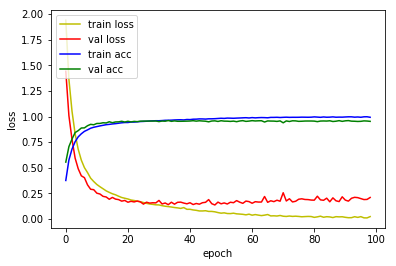

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1810 - acc: 0.9487
Loss: 0.18097060811884802 Accuracy: 0.948702

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5759 - acc: 0.5020
Epoch 00001: val_loss improved from inf to 0.89477, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_9_conv_checkpoint/001-0.8948.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 1.5759 - acc: 0.5020 - val_loss: 0.8948 - val_acc: 0.7421
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8339 - acc: 0.7448
Epoch 00002: val_loss improved from 0.89477 to 0.51750, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_9_conv_checkpoint/002-0.5175.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.8338 - acc: 0.7449 - val_loss: 0.5175 - val_acc: 0.8526
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9753
Epoch 00024: val_loss did not improve from 0.12337
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0788 - acc: 0.9753 - val_loss: 0.1293 - val_acc: 0.9627
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0714 - acc: 0.9782
Epoch 00025: val_loss did not improve from 0.12337
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0714 - acc: 0.9782 - val_loss: 0.1486 - val_acc: 0.9581
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9787
Epoch 00026: val_loss did not improve from 0.12337
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0713 - acc: 0.9787 - val_loss: 0.1307 - val_acc: 0.9604
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.9805
Epoch 00027: val_loss did not improve from 0.12337
36805/36805 [===========

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9958
Epoch 00053: val_loss did not improve from 0.12275
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0146 - acc: 0.9958 - val_loss: 0.1568 - val_acc: 0.9646
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9955
Epoch 00054: val_loss did not improve from 0.12275
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0146 - acc: 0.9955 - val_loss: 0.1630 - val_acc: 0.9632
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9957
Epoch 00055: val_loss did not improve from 0.12275
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0155 - acc: 0.9957 - val_loss: 0.1881 - val_acc: 0.9574
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9936
Epoch 00056: val_loss did not improve from 0.12275
36805/36805 [===========

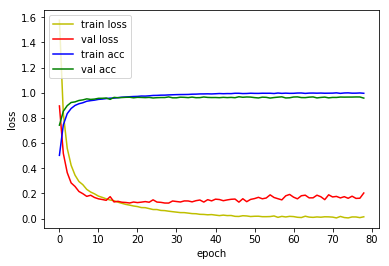

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1803 - acc: 0.9516
Loss: 0.18033145975131978 Accuracy: 0.95160955



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_conv_3_VGG_tanh_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_tanh_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.0789 - acc: 0.6908
Loss: 1.0788706494764129 Accuracy: 0.69075805

1D_CNN_custom_conv_3_VGG_tanh_DO_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_111 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_112 (Activation)

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4952 - acc: 0.8627
Loss: 0.4951543708085271 Accuracy: 0.86272067

1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_133 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_134 (Activation)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1810 - acc: 0.9487
Loss: 0.18097060811884802 Accuracy: 0.948702

1D_CNN_custom_conv_3_VGG_tanh_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_162 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_163 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_164 (Activation) 

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

with open(path.join(log_dir, base+'_last'), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.4097 - acc: 0.7161
Loss: 1.4096859444215166 Accuracy: 0.7160955

1D_CNN_custom_conv_3_VGG_tanh_DO_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_111 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_112 (Activation) 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.5414 - acc: 0.8733
Loss: 0.5414140965275056 Accuracy: 0.8733126

1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_133 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_134 (Activation) 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2546 - acc: 0.9450
Loss: 0.2545633427661419 Accuracy: 0.94496363

1D_CNN_custom_conv_3_VGG_tanh_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_162 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_163 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_164 (Activation)